# **XGAN: Unsupervised Image-to-Image Translation for Many-to-Many Mapping Problems**

Implementation of XGAN model for automatic cartoon generation from real faces. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/Leinadh/PeruvianImageGenerator.git

Cloning into 'PeruvianImageGenerator'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17028 (delta 4), reused 15 (delta 2), pack-reused 17008
Receiving objects: 100% (17028/17028), 655.57 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Checking out files: 100% (17631/17631), done.


In [ ]:
!cd PeruvianImageGenerator/; git pull

Se han truncado las últimas 5000 líneas del flujo de salida.
 .../Amaury_Nolasco_1_wo_bg.jpg                         | Bin 0 -> 16672 bytes
 .../Amber_Riley_1_wo_bg.jpg                            | Bin 0 -> 31905 bytes
 .../America_Ferrera_1_wo_bg.jpg                        | Bin 0 -> 131121 bytes
 .../Amitabh_Bachchan_1_wo_bg.jpg                       | Bin 0 -> 39047 bytes
 .../Amy_Davidson_1_wo_bg.jpg                           | Bin 0 -> 12413 bytes
 .../Amy_Nuttall_1_wo_bg.jpg                            | Bin 0 -> 39477 bytes
 .../Amy_Poehler_1_wo_bg.jpg                            | Bin 0 -> 8885 bytes
 .../Amy_Schumer_1_wo_bg.jpg                            | Bin 0 -> 17021 bytes
 .../Ana_Gasteyer_1_wo_bg.jpg                           | Bin 0 -> 11625 bytes
 .../Ana_Ivanovic_1_wo_bg.jpg                           | Bin 0 -> 49979 bytes
 .../Ana_Mulvoy-Ten_1_wo_bg.jpg                         | Bin 0 -> 4052 bytes
 .../Anastasia_Griffith_1_wo_bg.jpg                     | Bin 0 -> 1827

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from PIL import Image

import logging

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
c = torch.tensor([[ 1, 2, 3],[-1, -1, 4]] , dtype= torch.float)

In [ ]:
c.shape

torch.Size([2, 3])

In [ ]:
c = c.view(-1,3)

In [ ]:
c

tensor([[ 1.,  2.,  3.],
        [-1., -1.,  4.]])

In [ ]:
torch.norm(c,p=2,dim=-1)

tensor([3.7417, 4.2426])

In [ ]:
torch.mean(torch.norm(c,p=2,dim=1))

tensor(3.9921)

In [ ]:
torch.norm(c,dim=1)

tensor([3.7417, 4.2426])

In [ ]:
### hyperparameters ###

batch_size = 32

image_size = 64
use_gpu = True
workers = 4

## Preprocessing images - faces

In [ ]:
import cv2
import helper

(254, 222, 3)


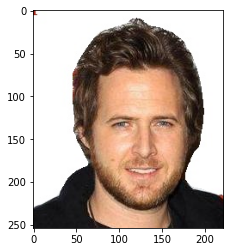

In [ ]:
path_faces = '/content/PeruvianImageGenerator/datasets/face_datasets/face_images_wo_bg_permissive/'

img = cv2.imread(path_faces + 'A.J._Buckley_1_wo_bg.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)
plt.show()

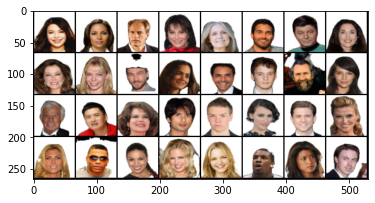

In [ ]:
path_faces = '/content/PeruvianImageGenerator/datasets/face_datasets/'

transform = transforms.Compose([
                transforms.Resize((image_size,image_size)) ,
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataset_faces = torchvision.datasets.ImageFolder(path_faces, transform=transform)

train_dataset_faces, test_dataset_faces = torch.utils.data.random_split(dataset_faces,
                                                                                (int(len(dataset_faces)*0.9),len(dataset_faces) - int(len(dataset_faces)*0.9)))


train_loader_faces = torch.utils.data.DataLoader(
    train_dataset_faces,
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

test_loader_faces = torch.utils.data.DataLoader(
    test_dataset_faces,
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(train_loader_faces)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0))

# Preprocessing cartoons

(500, 500, 3)


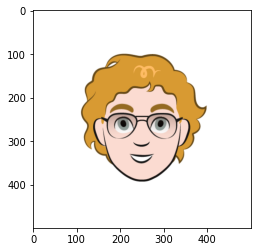

In [ ]:
path_cartoons = '/content/PeruvianImageGenerator/datasets/cartoon_datasets/cartoonset10k/'

img = cv2.imread(path_cartoons + 'cs1048486361028912.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
plt.imshow(img)
plt.show()

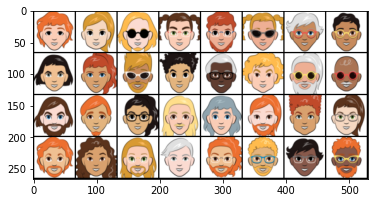

In [ ]:
path_cartoons = '/content/PeruvianImageGenerator/datasets/cartoon_datasets/'

transform = transforms.Compose([
                transforms.CenterCrop(300),
                transforms.Resize((image_size,image_size)) ,
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])


dataset_cartoons = torchvision.datasets.ImageFolder(path_cartoons, transform=transform)

train_dataset_cartoons, test_dataset_cartoons = torch.utils.data.random_split(dataset_cartoons,
                                                                                (int(len(dataset_cartoons)*0.9),len(dataset_cartoons) - int(len(dataset_cartoons)*0.9)))


train_loader_cartoons = torch.utils.data.DataLoader(
    train_dataset_cartoons,
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

test_loader_cartoons = torch.utils.data.DataLoader(
    test_dataset_cartoons,
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(train_loader_cartoons)
images_cartoon = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

## XGAN Model

### Classes

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b1 = nn.BatchNorm2d(32) 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False) #out: 16 x 16 x 64
    self.b2 = nn.BatchNorm2d(64) 

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = self.b1(x)
    x = F.relu(self.conv2(x))
    x = self.b2(x)

    return x  


class Eshared(nn.Module):
  def __init__(self, dropout_rate):
    super(Eshared, self).__init__()
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False)
    self.b3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False)
    self.b4 = nn.BatchNorm2d(256)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*256, out_features = 1024, bias=False)
    self.bfc1 = nn.BatchNorm1d(1024)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.fc2 = nn.Linear(in_features = 1024, out_features = 1024, bias=False)
    self.bfc2 = nn.BatchNorm1d(1024)

  def forward(self,x):
    x = F.relu(self.conv3(x))
    x = self.b3(x)
    x = F.relu(self.conv4(x))
    x = self.b4(x)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.bfc1(x)
    x = self.dropout2(x)      
    x = F.relu(self.fc2(x))
    x = self.bfc2(x) 

    return x
    

class Dshared(nn.Module):
  def __init__(self):
    super(Dshared, self).__init__()
    #c = capacity
    self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, bias=False)
    self.bd1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, bias=False)
    self.bd2 = nn.BatchNorm2d(256)
  
  def forward(self,x):
    x = x.view(-1,1024,1,1)
    x = F.relu(self.deconv1(x))
    x = self.bd1(x)
    x = F.relu(self.deconv2(x))
    x = self.bd2(x)

    return x

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, bias=False)
    self.bd3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, bias=False)
    self.bd4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = self.bd3(x)
    x = F.relu(self.deconv4(x))
    x = self.bd4(x)
    x = torch.tanh(self.deconv5(x))

    return x


class GradReverse(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x):
    return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
    return grad_output.neg() * 0.5


def grad_reverse(x):
  return GradReverse.apply(x)


class Cdann(nn.Module):
  def __init__(self, dropout_rate):
    super(Cdann, self).__init__()
    self.fc1 = nn.Linear(in_features = 1024, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512 , out_features = 256)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.fc3 = nn.Linear(in_features = 256 , out_features = 128)
    self.fc4 = nn.Linear(in_features = 128 , out_features = 64)
    self.dropout4 = nn.Dropout(dropout_rate)
    self.fc5 = nn.Linear(in_features = 64 , out_features = 32)
    self.fc6 = nn.Linear(in_features = 32 , out_features = 16)
    self.dropout6 = nn.Dropout(dropout_rate)
    self.fc7 = nn.Linear(in_features = 16, out_features = 1)

  def forward(self, x):
    x = grad_reverse(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.dropout4(x)
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = self.dropout6(x)
    x = torch.sigmoid(self.fc7(x))

    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32 
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b3 = nn.BatchNorm2d(32)  
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32 
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*32, out_features = 1)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.b2(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.b3(x)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = self.flatten(x)
    x = torch.sigmoid(self.fc1(x))

    return x

### Loss functions

In [ ]:
def Lrec(image_rec, image_orig):

  image_rec_r = image_rec.view(-1,64*64*3)
  image_orig_r = image_orig.view(-1,64*64*3)
  #mse
  rec_loss = torch.norm(image_rec_r - image_orig_r, p=2, dim=1)
  rec_loss = torch.mean(rec_loss)


  return rec_loss

  # criterion_MSE = nn.MSELoss()
  
  # return criterion_MSE(image_rec, image_orig)



def Lsem(encoder,encoder_rec):

  encoder = encoder.view(-1,1024)
  encoder_rec = encoder_rec.view(-1,1024)

  sem_loss = torch.norm(encoder - encoder_rec, p=1, dim=1)
  
  sem_loss = torch.mean(sem_loss)

  return sem_loss 

  # criterion_L1 = nn.L1Loss()

  # return criterion_L1(encoder, encoder_rec)

## Utils

In [ ]:
def init_logger(log_file=None, log_dir=None):
  
  fmt = '%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s: %(message)s'

  if log_dir is None:
    log_dir = '~/temp/log/'

  if not os.path.exists(log_dir):
        print("Creating dir")
        os.makedirs(log_dir)

  log_file = os.path.join(log_dir, log_file)

  print('log file path:' + log_file)

  logging.basicConfig(level=logging.INFO,
                      filename=log_file,
                      format=fmt)
  
  
  return logging  

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #print('Applied to:: ', m.__class__.__name__)
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.kaiming_uniform_(m.weight.data )
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_weights(path, n):
  
  torch.save(e1.state_dict(), os.path.join(path, 'e1.pth'))
  torch.save(e2.state_dict(), os.path.join(path, 'e2.pth'))
  torch.save(e_shared.state_dict(), os.path.join(path, 'e_shared.pth'))
  torch.save(d_shared.state_dict(), os.path.join(path, 'd_shared.pth'))
  torch.save(d1.state_dict(), os.path.join(path, 'd1.pth'))
  torch.save(d2.state_dict(), os.path.join(path, 'd2.pth'))
  torch.save(c_dann.state_dict(), os.path.join(path, 'c_dann.pth'))
  torch.save(discriminator1.state_dict(), os.path.join(path, 'disc1.pth'))


## Architecture


In [ ]:
e1 = Encoder()
e2 = Encoder()
e_shared = Eshared(0.5)
d_shared = Dshared()
d1 = Decoder()
d2 = Decoder()

c_dann = Cdann(0.5)

discriminator1 = Discriminator()
discriminator2 = Discriminator()

## Optimizers


In [ ]:
learning_rate_opTotal = 1e-4

learning_rate_opDisc = 1e-3
b1_disc = 0.5

learning_rate_opCdann = 1e-3
b1_cdann = 0.99


In [ ]:
listDisc1 = list(discriminator1.parameters())
optimizerDisc1 = torch.optim.Adam(listDisc1, lr=learning_rate_opDisc, betas=(b1_disc, 0.999))

listParameters = list(e1.parameters()) + list(e2.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d1.parameters()) + list(d2.parameters())
optimizerTotal = torch.optim.RMSprop(listParameters, lr=learning_rate_opTotal, weight_decay=0.01)
# optimizerTotal = torch.optim.Adam(listParameters, lr=learning_rate)

optimizerCdann = torch.optim.Adam(c_dann.parameters(), lr=learning_rate_opCdann, betas=(b1_cdann, 0.999))

In [ ]:
criterion_bc = nn.BCELoss()

## GPU

In [ ]:
print("it is cuda available? ", torch.cuda.is_available())
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

it is cuda available?  True


In [ ]:
e1.to(device)
e2.to(device)
e_shared.to(device)
d_shared.to(device)
d1.to(device)
d2.to(device)
c_dann.to(device)
discriminator1.to(device)
discriminator2.to(device)

criterion_bc.to(device) 

BCELoss()

## Weights init

In [ ]:
e1.apply(weights_init)
e2.apply(weights_init)
e_shared.apply(weights_init)
d_shared.apply(weights_init)
d1.apply(weights_init)
d2.apply(weights_init)
c_dann.apply(weights_init)
discriminator1.apply(weights_init)
discriminator2.apply(weights_init)
print("Init done")

Init done


In [ ]:
e1.train()
e2.train()
e_shared.train()
d_shared.train()
d1.train()
d2.train()
c_dann.train()
discriminator1.train()
discriminator2.train()

## Training

In [ ]:
save_cp = True

if save_cp:
  path_save_weights = "/content/drive/My Drive/Made with ML/weights_train_stev_v4/"

  try:
      os.mkdir(path_save_weights)
  except OSError:
      pass

In [ ]:
# wd = 
ws = 0.5
wg = 0.7

num_epochs = 300

In [ ]:

logging = init_logger(log_file='logfile.log',log_dir=path_save_weights)

logging.info(f'Using device {device}')

logging.info(f'''Starting training:
Epochs:             {num_epochs}
Batch size:         {batch_size}
Checkpoints:        {save_cp}
Device:             {device.type}

Optimizer generator: 
{optimizerTotal}

Optimizer cdann:   
{optimizerCdann} 

Optimizer discriminator 1->2: 
{optimizerDisc1}

Weights of losses:
w-semantic loss:    {ws}
w-gan loss:         {wg}
''')

log file path:/content/drive/My Drive/Made with ML/weights_train_stev_v4/logfile.log


In [ ]:
#EXECUTE THIS CELL, WORKs BETTER

train_loss_rec1 = []
train_loss_rec2 = []
train_loss_cdan = []
train_loss_sem1 = []
train_loss_sem2 = []
train_disc1 = []
train_gen1 = []
train_loss_total = []




for epoch in tqdm(range(num_epochs)):
  for faces_batch,cartoons_batch in zip(train_loader_faces, train_loader_cartoons):
    faces_batch,_ = faces_batch
    faces_batch = Variable(faces_batch.type(torch.Tensor))
    class_faces = Variable(torch.ones(faces_batch.size(0)))
    faces_batch = faces_batch.to(device)
    class_faces = class_faces.to(device)
    
    cartoons_batch,_ = cartoons_batch
    cartoons_batch = Variable(cartoons_batch.type(torch.Tensor))
    class_cartoons = Variable(torch.zeros(cartoons_batch.size(0)))
    cartoons_batch = cartoons_batch.to(device)
    class_cartoons = class_cartoons.to(device)
    
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d1.zero_grad()
    d2.zero_grad()
    c_dann.zero_grad()
    discriminator1.zero_grad()

    #architecture
    faces_enc1 = e1(faces_batch)
    faces_encoder = e_shared(faces_enc1)
    faces_decoder = d_shared(faces_encoder)
    faces_rec = d1(faces_decoder)
    cartoons_construct = d2(faces_decoder)
    cartoons_construct_enc2 = e2(cartoons_construct)
    cartoons_construct_encoder = e_shared(cartoons_construct_enc2)

    cartoons_enc2 = e2(cartoons_batch)
    cartoons_encoder = e_shared(cartoons_enc2)
    cartoons_decoder = d_shared(cartoons_encoder)
    cartoons_rec = d2(cartoons_decoder)
    faces_construct = d1(cartoons_decoder)
    faces_construct_enc1 = e1(faces_construct)
    faces_construct_encoder = e_shared(faces_construct_enc1)


    #discriminator face(1)->cartoon(2)

      #train discriminator
    data_cartoons = torch.cat([cartoons_batch, cartoons_construct.detach()], 0)
    label_class = torch.cat([class_cartoons, class_faces], 0)   
    output = discriminator1(data_cartoons) 
    loss_disc1 = criterion_bc(output.squeeze(), label_class)
    loss_disc1.backward()
    optimizerDisc1.step()

    #train generator
    data_classifier = torch.cat([faces_encoder, cartoons_encoder], 0)
    label_classifier = torch.cat([class_faces, class_cartoons], 0)

    label_output = c_dann(data_classifier) 


    loss_rec1 = Lrec(faces_batch, faces_rec)
    loss_rec2 = Lrec(cartoons_batch, cartoons_rec)
    loss_rec =  loss_rec1 + loss_rec2

    error_classifier = criterion_bc(label_output.squeeze(),label_classifier) 

    loss_sem1 = Lsem(faces_encoder.detach(), cartoons_construct_encoder) 
    loss_sem2 = Lsem(cartoons_encoder.detach(), faces_construct_encoder) 
    loss_sem = loss_sem1 + loss_sem2

          
    class_faces.fill_(0)

    output = discriminator1(cartoons_construct)

    loss_gen1 = criterion_bc(output.squeeze(), class_faces)



    loss_total = loss_rec + error_classifier + ws*loss_sem + wg*loss_gen1
    loss_total.backward()


    optimizerTotal.step()
    optimizerCdann.step()


  logging.info('Train Epoch [{}/{}], Loss rec1: {:.4f}, Loss rec2: {:.4f},'
                                    ' Loss classifier: {:.4f}, Loss semantic 1->2: {:.4f}, Loss semantic 2->1: {:.4f},'
                                    ' Loss disc1: {:.4f}, Loss gen1: {:.4f}, Loss total: {:.4f}'
                                    .format(epoch+1, num_epochs, loss_rec1.item(),
                                            loss_rec2.item(), error_classifier.item(),
                                            loss_sem1.item(), loss_sem2.item(),
                                            loss_disc1.item(), loss_gen1.item(), loss_total.item()))


  if save_cp and ((epoch+1)%25)==0:
    path_save_epoch = path_save_weights + 'epoch_{}'.format(epoch+1)
    try:
        os.mkdir(path_save_epoch)
    except OSError:
        pass
    save_weights(path_save_epoch, epoch)
    logging.info(f'Checkpoint {epoch + 1} saved !')

  train_loss_rec1.append(loss_rec1.item())
  train_loss_rec2.append(loss_rec2.item())
  train_loss_cdan.append(error_classifier.item())
  train_loss_sem1.append(loss_sem1.item())
  train_loss_sem2.append(loss_sem2.item())
  train_disc1.append(loss_disc1.item())
  train_gen1.append(loss_gen1.item())
  train_loss_total.append(loss_total.item())

  print("Losses")
  print('Epoch [{}/{}], Loss rec1: {:.4f}'.format(epoch+1, num_epochs, loss_rec1.item()))
  print('Epoch [{}/{}], Loss rec2: {:.4f}'.format(epoch+1, num_epochs, loss_rec2.item()))
  print('Epoch [{}/{}], Loss classifier: {:.4f}'.format(epoch+1, num_epochs, error_classifier.item()))
  print('Epoch [{}/{}], Loss semantic 1->2: {:.4f}'.format(epoch+1, num_epochs, loss_sem1.item()))
  print('Epoch [{}/{}], Loss semantic 2->1: {:.4f}'.format(epoch+1, num_epochs, loss_sem2.item()))    
  print('Epoch [{}/{}], Loss disc1: {:.4f}'.format(epoch+1, num_epochs, loss_disc1.item()))
  print('Epoch [{}/{}], Loss gen1: {:.4f}'.format(epoch+1, num_epochs, loss_gen1.item()))
  print('Epoch [{}/{}], Loss total: {:.4f}'.format(epoch+1, num_epochs, loss_total.item()))

Losses
Epoch [1/300], Loss rec1: 117.0801
Epoch [1/300], Loss rec2: 117.8661
Epoch [1/300], Loss classifier: 0.2759
Epoch [1/300], Loss semantic 1->2: 746.5404
Epoch [1/300], Loss semantic 2->1: 682.7875
Epoch [1/300], Loss disc1: 0.0004
Epoch [1/300], Loss gen1: 1.0447
Epoch [1/300], Loss total: 950.6173
Losses
Epoch [2/300], Loss rec1: 98.6352
Epoch [2/300], Loss rec2: 106.8113
Epoch [2/300], Loss classifier: 0.0747
Epoch [2/300], Loss semantic 1->2: 598.1124
Epoch [2/300], Loss semantic 2->1: 562.6125
Epoch [2/300], Loss disc1: 0.0001
Epoch [2/300], Loss gen1: 0.8616
Epoch [2/300], Loss total: 786.4867
Losses
Epoch [3/300], Loss rec1: 64.2534
Epoch [3/300], Loss rec2: 67.2067
Epoch [3/300], Loss classifier: 0.0796
Epoch [3/300], Loss semantic 1->2: 296.0818
Epoch [3/300], Loss semantic 2->1: 343.8742
Epoch [3/300], Loss disc1: 0.0009
Epoch [3/300], Loss gen1: 0.4752
Epoch [3/300], Loss total: 451.8504
Losses
Epoch [4/300], Loss rec1: 57.6396
Epoch [4/300], Loss rec2: 48.8834
Epoch [

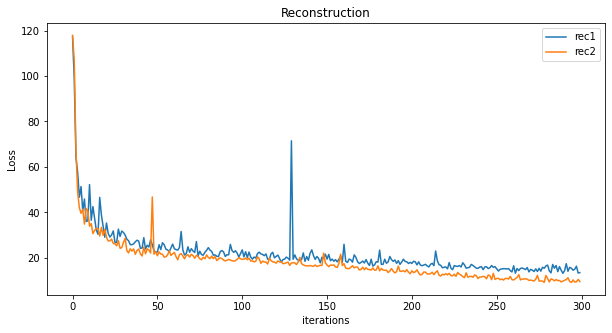

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Reconstruction")
plt.plot(train_loss_rec1,label="rec1")
plt.plot(train_loss_rec2,label="rec2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

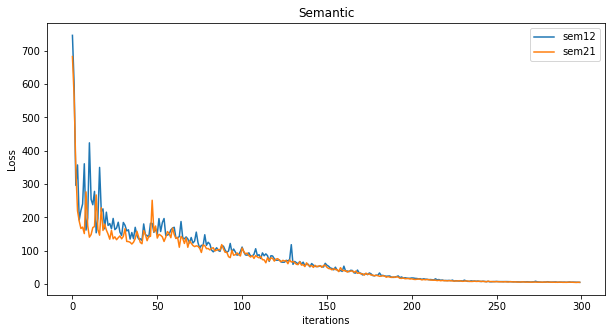

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Semantic")
plt.plot(train_loss_sem1,label="sem12")
plt.plot(train_loss_sem2,label="sem21")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

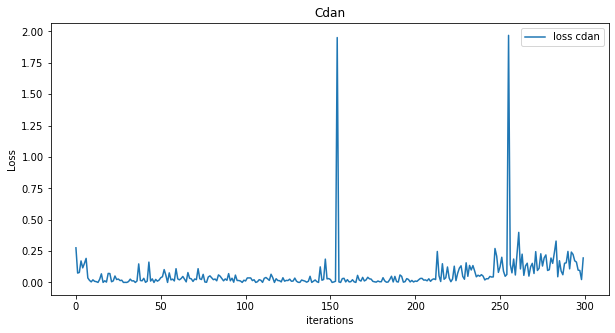

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Cdan")
plt.plot(train_loss_cdan,label="loss cdan")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

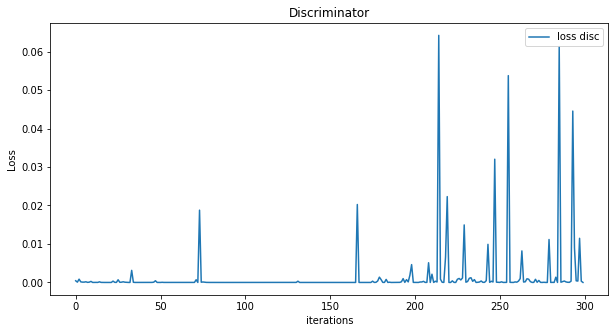

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator")
plt.plot(train_disc1,label="loss disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

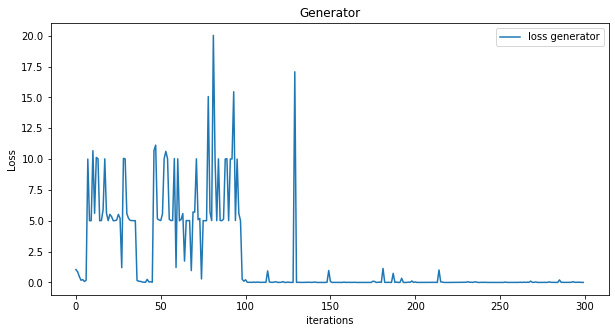

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator")
plt.plot(train_gen1,label="loss generator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

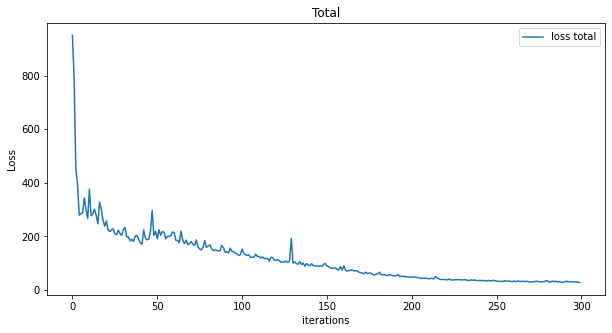

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Total")
plt.plot(train_loss_total,label="loss total")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Validating model

In [ ]:
def load_weights_xgan(path_load_weights, e1, e2, e_shared, d_shared, d1, d2):
  
  e1.load_state_dict(torch.load(path_load_weights + 'e1.pth'))
  e2.load_state_dict(torch.load(path_load_weights + 'e2.pth'))
  e_shared.load_state_dict(torch.load(path_load_weights + 'e_shared.pth'))
  d_shared.load_state_dict(torch.load(path_load_weights + 'd_shared.pth'))
  d1.load_state_dict(torch.load(path_load_weights + 'd1.pth'))
  d2.load_state_dict(torch.load(path_load_weights + 'd2.pth'))

  return

In [ ]:
e1.eval()
e2.eval()
e_shared.eval()
d_shared.eval()
d1.eval()
d2.eval()
c_dann.eval()
discriminator1.eval()
discriminator2.eval()

Discriminator(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten()
  (fc1): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
use_weights_just_trained = True

if not use_weights_just_trained:
  path_load_weights = "/content/drive/My Drive/Made with ML/weights_train_stev_v4/epoch_300/"
  load_weights_xgan(path_load_weights, e1, e2, e_shared, d_shared, d1, d2)



### Faces domain

#### Original faces

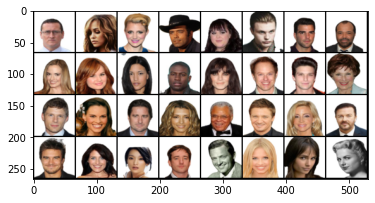

In [ ]:
dataiter = iter(test_loader_faces)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0))

#### Rec faces

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


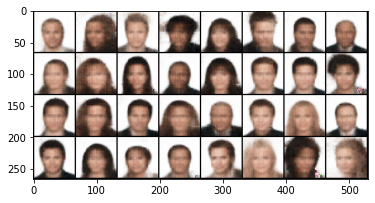

In [ ]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

#### Face to cartoon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


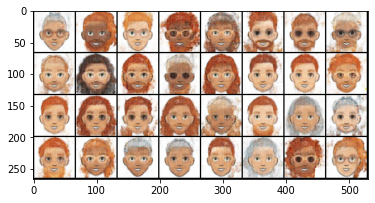

In [ ]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

### Cartoons domain

#### Original cartoons

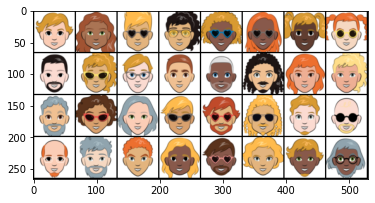

In [ ]:
dataiter = iter(test_loader_cartoons)
images_cartoon = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

#### Rec cartoon


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


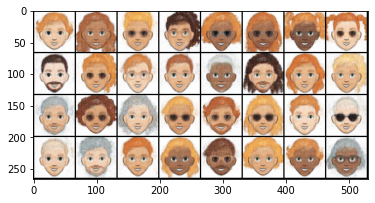

In [ ]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

#### Cartoon to face

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


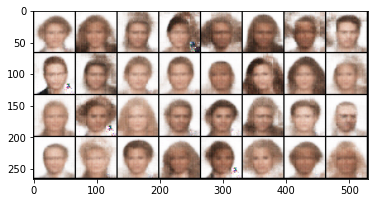

In [ ]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  
# grid4 = torchvision.utils.make_grid(output.cpu(), nrow=1)
# plt.figure(figsize=(12, 12))
# plt.imshow(grid4.permute(1, 2, 0))



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

## Testing model

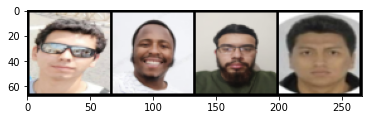

In [ ]:
path_test_images = '/content/drive/My Drive/Made with ML/datasets/faces_pucp/'

transform = transforms.Compose([
                               
                transforms.Resize((image_size,image_size)) ,
                transforms.CenterCrop(64), 
                transforms.ToTensor(),
                # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                ])

dataset_test_images = torchvision.datasets.ImageFolder(path_test_images, transform=transform)

test_loader_images = torch.utils.data.DataLoader(
    dataset_test_images,
    batch_size=batch_size,
    shuffle=True,
    num_workers = workers)

dataiter = iter(test_loader_images)
test_images = dataiter.next()


plt.imshow(torchvision.utils.make_grid(test_images[0]).permute(1, 2, 0))

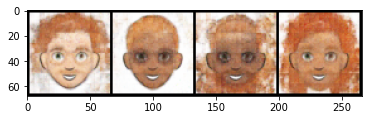

In [ ]:
with torch.no_grad():
    output = e1(test_images[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)

plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()